# Predictive Modeling 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\Thanh\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
original_data = pd.read_csv('processed_dataframe.csv')

In [3]:
df = original_data[[
    "avg_temp",
    "precip",
    "date",
    "hour",
    "weekday",
    "month",
    'start_station_id',
    'end_station_id',
    "bike_id",
    "trip_duration_min"]].copy()

In [4]:
original_data.columns

Index(['Unnamed: 0', 'start_time', 'end_time', 'start_station_id',
       'end_station_id', 'start_station_name', 'end_station_name', 'bike_id',
       'user_type', 'date', 'weekday', 'avg_temp', 'precip', 'hour', 'day',
       'month', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'trip_duration_min', 'start_coordinates', 'end_coordinates'],
      dtype='object')

In [5]:
df.pop("date")
df.insert(0, 'date', original_data[["date"]])

In [6]:
df['avg_temp']=df['avg_temp'].astype(float)
df['hour']=df['hour'].astype(float)
df['month']=df['month'].astype(float)
df['start_station_id']=df['start_station_id'].astype(float)
df['end_station_id']=df['end_station_id'].astype(float)
df['bike_id']=df['bike_id'].astype(float)
df['trip_duration_min']=df['trip_duration_min'].astype(float)

In [7]:
def is_weekday(weekday):
    if weekday in [0, 1, 2, 3, 4]:
        return 1
    else:
        return 0


In [8]:
df['IsWeekday'] = df['weekday'].apply(is_weekday)

In [9]:
# data.sort_values(by = "start_station_id", inplace=True)
df.head()

,date,avg_temp,precip,hour,weekday,month,start_station_id,end_station_id,bike_id,trip_duration_min,IsWeekday
0,2019-01-01,2.5,1.0,0.0,1,1.0,199.0,84.0,2167.0,7.0,1
1,2019-01-01,2.5,1.0,0.0,1,1.0,44.0,624.0,4386.0,8.0,1
2,2019-01-01,2.5,1.0,0.0,1,1.0,15.0,644.0,1524.0,14.0,1
3,2019-01-01,2.5,1.0,0.0,1,1.0,123.0,176.0,252.0,30.0,1
4,2019-01-01,2.5,1.0,0.0,1,1.0,173.0,35.0,1170.0,7.0,1


# Feature Engineering

1st Step: Aggregate hourly demands from the more granular (up to hour original dataframe) 

In [10]:
df_agg_h = df.groupby(['date', 'hour', 'weekday', 'month', 'avg_temp', 'precip', 'IsWeekday']).size().reset_index(name='count')
df_agg_h

,date,hour,weekday,month,avg_temp,precip,IsWeekday,count
0,2019-01-01,0.0,1,1.0,2.500,1.0,1,41
1,2019-01-01,1.0,1,1.0,1.650,1.0,1,48
2,2019-01-01,2.0,1,1.0,1.375,1.0,1,37
3,2019-01-01,3.0,1,1.0,1.100,1.0,1,17
4,2019-01-01,4.0,1,1.0,1.100,1.0,1,10
...,...,...,...,...,...,...,...,...
8734,2019-12-31,19.0,1,12.0,-3.300,0.0,1,80
8735,2019-12-31,20.0,1,12.0,-3.300,0.0,1,44
8736,2019-12-31,21.0,1,12.0,-3.300,0.0,1,36
8737,2019-12-31,22.0,1,12.0,-3.300,0.0,1,22


In [11]:
df_agg_h.rename(columns={'count': 'demand'}, inplace=True)

In [12]:
df_agg_h

,date,hour,weekday,month,avg_temp,precip,IsWeekday,demand
0,2019-01-01,0.0,1,1.0,2.500,1.0,1,41
1,2019-01-01,1.0,1,1.0,1.650,1.0,1,48
2,2019-01-01,2.0,1,1.0,1.375,1.0,1,37
3,2019-01-01,3.0,1,1.0,1.100,1.0,1,17
4,2019-01-01,4.0,1,1.0,1.100,1.0,1,10
...,...,...,...,...,...,...,...,...
8734,2019-12-31,19.0,1,12.0,-3.300,0.0,1,80
8735,2019-12-31,20.0,1,12.0,-3.300,0.0,1,44
8736,2019-12-31,21.0,1,12.0,-3.300,0.0,1,36
8737,2019-12-31,22.0,1,12.0,-3.300,0.0,1,22


## (Multiple) Linear Regression - Comparison of different Feature Selection

We want to use different (in the selection of features/dependent variables) linear regression models, to heuristically find important features. We do so by starting with a single feature ('hour) linear regression under the assumption that the time of the day ('hour') is the most signifcant feature. Afterwards we compare the resulting R^2's and Mean Squared Errors of the models to deduce whether different/multiple features yield significantly more predictive power of the model.  

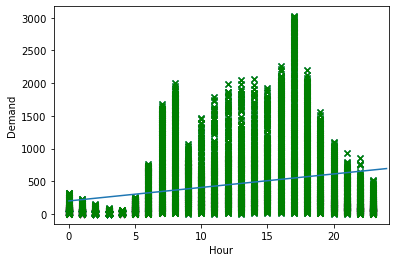

mean_squared_error :  247723.02194310064
mean_absolute_error :  368.22378790908976
[20.61601565] 199.4863559714655
The R^2 of linear regression is:  0.07581063214975758


In [13]:
# First perfomr regression on all months 
df_f = df_agg_h[list(map(lambda x : x in [1,2,3,4,5,6,7,8,9,10,11,12], df_agg_h["month"]))].copy()

xp = df_f['hour']

yp = df_f['demand']



plt.scatter(xp, yp, marker='x')
plt.xlabel("hour")
plt.ylabel("Demand")


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

model.fit(xp.values.reshape(-1,1),yp)
y_pred = model.predict(xp.values.reshape(-1,1))

plt.scatter( xp ,yp, marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(0,24)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.show()

# model evaluation
print('mean_squared_error : ', mean_squared_error(yp, y_pred))
print('mean_absolute_error : ', mean_absolute_error(yp, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(yp, y_pred))

### 1) Single-Variable Regression - Feature: 'Hour'
#### Hypothesis - Different prediction models for different season to improve accuracy since demand curves (and amplitudes) differ for different (e.g.) quarters/seasons
##### Scope: 1st Quarter

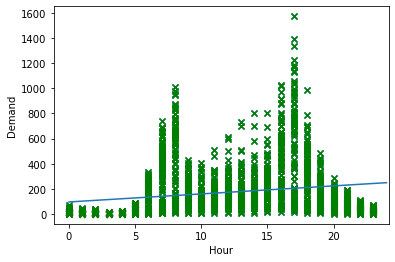

mean_squared_error :  41690.41809644244
mean_absolute_error :  144.68484824792102
[6.38780211] 96.17376255681803
The R^2 of linear regression is:  0.044613401869689095


In [14]:
# Regression for Jan-Mar
df_f = df_agg_h[list(map(lambda x : x in [1,2,3], df_agg_h["month"]))].copy()

xp = df_f['hour']

yp = df_f['demand']

yp



plt.scatter(xp, yp, marker='x')
plt.xlabel("hour")
plt.ylabel("Demand")


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

model.fit(xp.values.reshape(-1,1),yp)
y_pred = model.predict(xp.values.reshape(-1,1))

plt.scatter( xp ,yp, marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(0,24)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.show()

# model evaluation
print('mean_squared_error : ', mean_squared_error(yp, y_pred))
print('mean_absolute_error : ', mean_absolute_error(yp, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(yp, y_pred))

##### Scope: 2nd Quarter

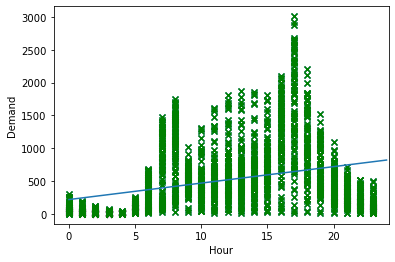

mean_squared_error :  245268.47783426192
mean_absolute_error :  374.869585664797
[25.04467998] 219.63382054214844
The R^2 of linear regression is:  0.10908378144654807


In [15]:
# Regression for Apr-Jun
df_f = df_agg_h[list(map(lambda x : x in [4,5,6], df_agg_h["month"]))].copy()

xp = df_f['hour']

yp = df_f['demand']

yp


plt.scatter(xp, yp, marker='x')
plt.xlabel("hour")
plt.ylabel("Demand")


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

model.fit(xp.values.reshape(-1,1),yp)
y_pred = model.predict(xp.values.reshape(-1,1))

plt.scatter( xp ,yp, marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(0,24)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.show()

# model evaluation
print('mean_squared_error : ', mean_squared_error(yp, y_pred))
print('mean_absolute_error : ', mean_absolute_error(yp, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(yp, y_pred))

##### Scope: 3rd Quarter

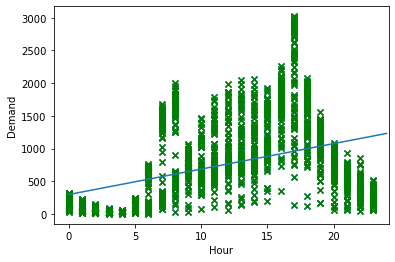

mean_squared_error :  349200.49693401996
mean_absolute_error :  454.62458361689124
[38.89138124] 298.04099360176633
The R^2 of linear regression is:  0.17133215856124118


In [16]:
# Regression for Jul-Sep
df_f = df_agg_h[list(map(lambda x : x in [7,8,9], df_agg_h["month"]))].copy()

xp = df_f['hour']

yp = df_f['demand']

yp


plt.scatter(xp, yp, marker='x')
plt.xlabel("hour")
plt.ylabel("Demand")


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

model.fit(xp.values.reshape(-1,1),yp)
y_pred = model.predict(xp.values.reshape(-1,1))

plt.scatter( xp ,yp, marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(0,24)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.show()

# model evaluation
print('mean_squared_error : ', mean_squared_error(yp, y_pred))
print('mean_absolute_error : ', mean_absolute_error(yp, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(yp, y_pred))

##### Scope: 4th Quarter

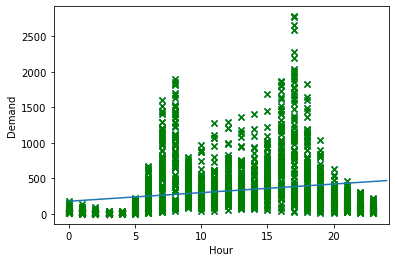

mean_squared_error :  136150.8923728474
mean_absolute_error :  258.8462301903258
[12.11550095] 179.53677536231885
The R^2 of linear regression is:  0.049121743681878605


In [17]:
# Regression for Oct-Dec
df_f = df_agg_h[list(map(lambda x : x in [10,11,12], df_agg_h["month"]))].copy()

xp = df_f['hour']

yp = df_f['demand']


plt.scatter(xp, yp, marker='x')
plt.xlabel("hour")
plt.ylabel("Demand")


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

model.fit(xp.values.reshape(-1,1),yp)
y_pred = model.predict(xp.values.reshape(-1,1))

plt.scatter( xp ,yp, marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(0,24)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.show()

# model evaluation
print('mean_squared_error : ', mean_squared_error(yp, y_pred))
print('mean_absolute_error : ', mean_absolute_error(yp, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(yp, y_pred))

### Results:
As the data (and plots of that) show, different time-scopes (such as 1st to 4th quarter) have different demand patterns. E.g. demand in 2nd and 3rd quarter is on average higher than in the 1st (max demand at 1.5k) and 4th quarter

##### --> It seems suitable to use different prediction models (though non of the linear models above, as all result in very low R^2 between 5%-20% independent of the scope) for different quarters/seasons/.

### Trying other features for single variable linear regression

##### Month 

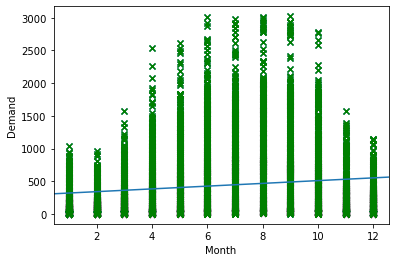

mean_squared_error :  262764.29357545514
mean_absolute_error :  386.7655632025408
[21.08471796] 299.1361647006282
The R^2 of linear regression is:  0.019695608150242516


In [18]:
df_f = df_agg_h[list(map(lambda x : x in [1,2,3,4,5,6,7,8,9,10,11,12], df_agg_h["month"]))].copy()

xp = df_f['month']

yp = df_f['demand']

plt.scatter(xp, yp, marker='x')
plt.xlabel("hour")
plt.ylabel("Demand")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

model.fit(xp.values.reshape(-1,1),yp)
y_pred = model.predict(xp.values.reshape(-1,1))

plt.scatter( xp ,yp, marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(0,24)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Month")
plt.ylabel("Demand")
plt.show()

# model evaluation
print('mean_squared_error : ', mean_squared_error(yp, y_pred))
print('mean_absolute_error : ', mean_absolute_error(yp, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(yp, y_pred))

##### Weekday

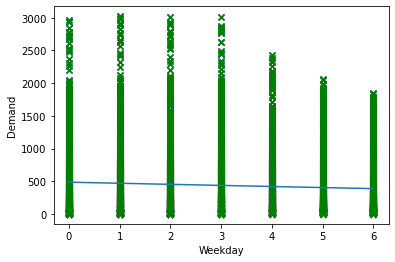

mean_squared_error :  262764.29357545514
mean_absolute_error :  386.7655632025408
[-16.43808444] 486.14473084612365
The R^2 of linear regression is:  0.019695608150242516


In [19]:
df_f = df_agg_h[list(map(lambda x : x in [1,2,3,4,5,6,7,8,9,10,11,12], df_agg_h["month"]))].copy()

xp = df_f['weekday']

yp = df_f['demand']

plt.scatter(xp, yp, marker='x')
plt.xlabel("hour")
plt.ylabel("Demand")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

model.fit(xp.values.reshape(-1,1),yp)
model_pred = model.predict(xp.values.reshape(-1,1))

plt.scatter( xp ,yp, marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(0,6)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Weekday")
plt.ylabel("Demand")
plt.show()

# model evaluation
print('mean_squared_error : ', mean_squared_error(yp, y_pred))
print('mean_absolute_error : ', mean_absolute_error(yp, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(yp, y_pred))

##### Average Temperature

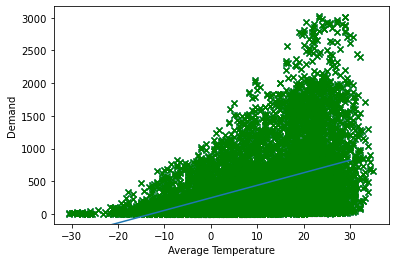

mean_squared_error :  262764.29357545514
mean_absolute_error :  386.7655632025408
[19.17351049] 247.14343815905067
The R^2 of linear regression is:  0.019695608150242516


In [20]:
df_f = df_agg_h[list(map(lambda x : x in [1,2,3,4,5,6,7,8,9,10,11,12], df_agg_h["month"]))].copy()

xp = df_f['avg_temp']

yp = df_f['demand']

plt.scatter(xp, yp, marker='x')
plt.xlabel("Average Temperature")
plt.ylabel("Demand")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

model.fit(xp.values.reshape(-1,1),yp)
model_pred = model.predict(xp.values.reshape(-1,1))

plt.scatter( xp ,yp, marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(-30,30)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Average Temperature")
plt.ylabel("Demand")
plt.show()

# model evaluation
print('mean_squared_error : ', mean_squared_error(yp, y_pred))
print('mean_absolute_error : ', mean_absolute_error(yp, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(yp, y_pred))

### Multiple-Feature Regression
### - 2.1) Features: "Complete Dataframe" (Hour, Weekday, Month, Average Temparature, Precip, IsWeekday)

In [21]:
df_f = df_agg_h[list(map(lambda x : x in [6,7,8], df_agg_h["month"]))].copy()

xp = df_f.drop(['demand', 'date'],axis= 1)

yp = df_f['demand'].copy()

In [22]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size = 0.2, random_state = 42)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

In [24]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [25]:
# model evaluation
print('mean_squared_error : ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(y_test, y_pred))

mean_squared_error :  304092.0014086734
mean_absolute_error :  421.16490457994126
[  41.21042787    8.47636866   63.36110514  -11.92489884 -254.12461232
   84.62950633] 16.18535839678873
The R^2 of linear regression is:  0.2168122871437077


### Multiple-Feature Regression 
### - 2.2) Features: "Time" (Hour, Weekday, Month, IsWeekday)

In [26]:
df_f = df_agg_h[list(map(lambda x : x in [6,7,8], df_agg_h["month"]))].copy()

xp = df_f[['hour', 'month', 'weekday','IsWeekday']]

yp = df_f['demand'].copy()

In [27]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size = 0.2, random_state = 42)

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

In [29]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [30]:
# model evaluation
print('mean_squared_error : ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred))

mean_squared_error :  302596.794869809
mean_absolute_error :  421.40808510850724


In [31]:
# model evaluation
print('mean_squared_error : ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(y_test, y_pred))

mean_squared_error :  302596.794869809
mean_absolute_error :  421.40808510850724
[38.52563322 51.82018679 11.78882876 96.5174174 ] -169.41108904023952
The R^2 of linear regression is:  0.22066318550340247


### Multiple-Feature Regression 
### - 2.3) Features: Hour, Avg_Temp, Month

In [32]:
df_f = df_agg_h[list(map(lambda x : x in [6,7,8], df_agg_h["month"]))].copy()

xp = df_f[['hour','avg_temp', 'month']]

yp = df_f['demand'].copy()

In [33]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size = 0.2, random_state = 42)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

In [35]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [36]:
# model evaluation
print('mean_squared_error : ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred))

print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(y_test, y_pred))

mean_squared_error :  302322.80689103866
mean_absolute_error :  419.321351169442
[ 40.86799935 -10.3162625   67.92507811] 27.14620756905981
The R^2 of linear regression is:  0.2213688404283899


### Results of comparison
The multiple feature regression model  yields unproportionally "better" (higher R^2) predictions than the single variable (using "hour", as the most significant feature) regression model. The R^2 are low in any case, implying weak predictive power of the models. 
Explicitly / "in" numbers: Multiple regression models give R^2 between 20-22% which is only insignificantly higher than 18% in the single variable model -  considering that one might expect (significant) increases when successively adding more (relevant) features. 
-> Analoguous statements can be made about the differences in the MSE/MAE of the different models. Adding features / using different feature combinations does not significantly reduce the MSEs/MAEs. 
--> Going on, we will use "hour" as the only feature in polynomial regression.


### Polynomial Regression

In [37]:
xp = df_f['hour']

yp = df_f['demand']

In [38]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    
    #Scaling data using min-max method
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1
    
    #Creating Polynomial features
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    #Solving normal equation and finding coefficients
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    #Calculating Mean Squared Error
    predictions = X @ theta
    mse = ((predictions - y) ** 2).mean()
    print("Mean Squared Error: ", mse)

    #Calculating R^2 value
    r_squared = 1 - (np.sum((y - predictions) ** 2)) / (np.sum((y - y.mean()) ** 2))
    print("R^2 Value: ", r_squared)

    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Hour")
    plt.ylabel("Demand")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])
    #plt.savefig('all data_reg_'+str(d)+'.png', dpi = 300)

We first perform a polynomial regression on the whole dataset, without segmentation in 1) weekday and 2) weekends.

Mean Squared Error:  182388.67144161483
R^2 Value:  0.5512940804959208
[-311.74691937 -286.04255574 -894.85313663 -741.01114092]


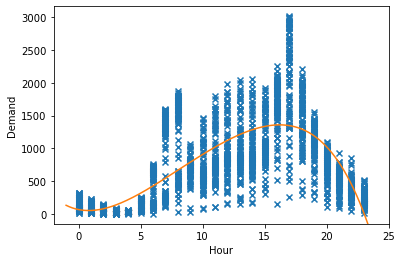

In [39]:
plot_regression_poly(x = xp, y=yp, d = 5)
plt.savefig('test'+str(5)+'.png', dpi = 1200)

Mean Squared Error:  136645.94425352066
R^2 Value:  0.6638286600908403
[-19292.63142694   8764.49568621  44666.95696332 -15338.59693576]


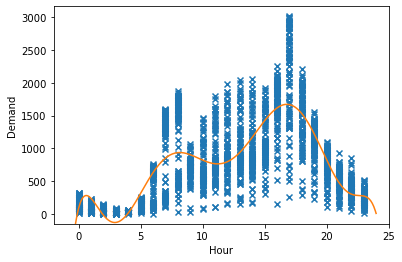

In [40]:
plot_regression_poly(x = xp, y=yp, d = 8)

###### -- Regression for: Weekday

For the weekdays, we expect 2 different (local) peaks at: 1) 7-8am and 2) 5-6pm and related dips in between at 3) lunch hours around 12am - 2pm and 4) during the night). Our first guess might be a d = 4 degree polynomial.

In [41]:
xp_weekday = df_f[df_f["IsWeekday"]==True]["hour"]
yp_weekday = df_f[df_f["IsWeekday"]==True]["demand"]

xp_weekend = df_f[df_f["IsWeekday"]==False]["hour"]
yp_weekend = df_f[df_f["IsWeekday"]==False]["demand"]

Mean Squared Error:  204953.3990580837
R^2 Value:  0.525793818894019
[-1091.53094216 -1177.16868623    21.49716255  1225.24604973]


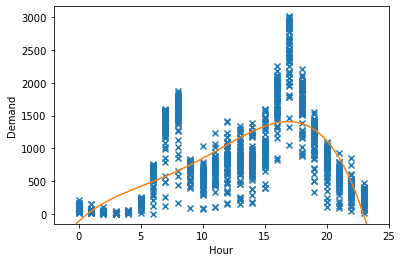

In [42]:
plot_regression_poly(x = xp_weekday, y=yp_weekday, d = 4)

This does not (graphically) sufficiently catch the complexity and patterns we want to model with above mentioned qualitative prior knowledge. So we increase the degree of the regression polynomial.

Mean Squared Error:  145826.62337087942
R^2 Value:  0.6625970269822785
[ 10408.63587633  -1135.41935683 -16258.76236035    177.38286861]


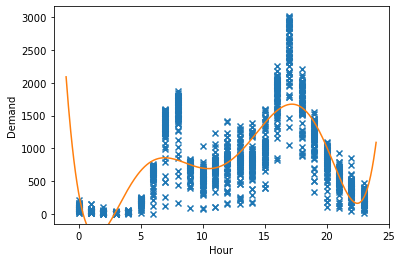

In [43]:
plot_regression_poly(x = xp_weekday, y=yp_weekday, d = 6)

Mean Squared Error:  98777.54904051313
R^2 Value:  0.7714557332311636
[-29282.29257448  12346.1305392   67926.43644936 -22299.32824211]


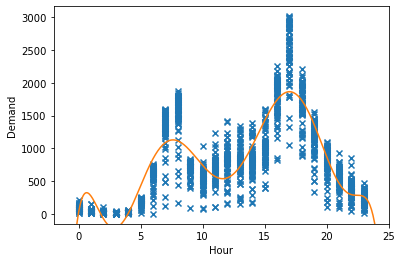

In [44]:
plot_regression_poly(x = xp_weekday, y=yp_weekday, d = 8)

d = 8 captures the demand on weekdays sufficiently well (graphically, quantitatve evaluation in the next section).

##### -- Regression for: Weekend

For the (on 1st glance, as seen above) less complex/fluctuating patterns of weekend demand, we expect a lower than d = 8 polynomial to be sufficient. 

Mean Squared Error:  102832.28894629474
R^2 Value:  0.6988494970269956
[-1484.32578932 -1049.17088123  1373.56370712  1069.96396801]


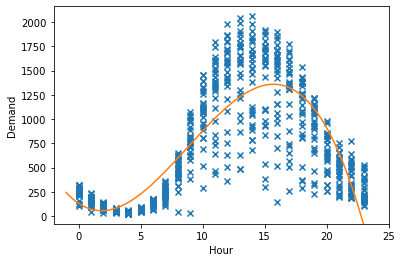

In [45]:
plot_regression_poly(x = xp_weekend, y=yp_weekend, d = 3)

Mean Squared Error:  81756.94195267696
R^2 Value:  0.7605699100654849
[ 1652.02824563 -1478.64991498 -2576.88256625  1370.89263037]


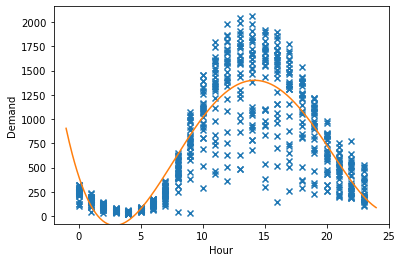

In [46]:
plot_regression_poly(x = xp_weekend, y=yp_weekend, d = 4)

Mean Squared Error:  76124.62180068145
R^2 Value:  0.7770644961926525
[ 1666.19655923  1657.88783197 -3467.9428108  -2581.80561103]


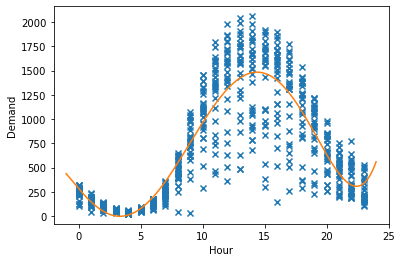

In [47]:
plot_regression_poly(x = xp_weekend, y=yp_weekend, d = 5)

As expected, a lower degree polynomial (d = 5) yields accurate graphical results in comparison to the weekday prediction.

##### - Regression for specific weather conditions: Sun (Precip = 0)

In [48]:
xp_sun = df_f[df_f["precip"]==0]["hour"]
yp_sun = df_f[df_f["precip"]==0]["demand"]

xp_rainsnow = df_f[df_f["precip"]==1]["hour"]
yp_rainsnow = df_f[df_f["precip"]==1]["demand"]

Mean Squared Error:  179799.08931652835
R^2 Value:  0.5602767261883861
[ -262.13294518 -1276.95897411  -775.00057149  1279.01988458]


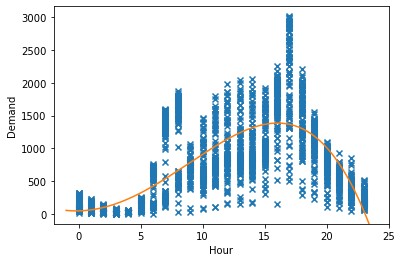

In [49]:
plot_regression_poly(x = xp_sun, y=yp_sun, d = 4)

Mean Squared Error:  156041.7276033433
R^2 Value:  0.6183786048428299
[  6719.25634914   -315.67290194 -10051.30117675   -900.12580388]


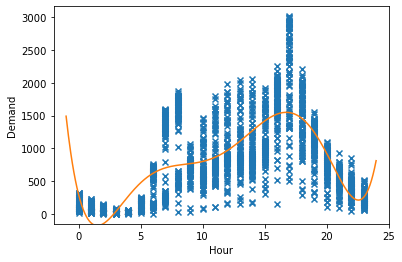

In [50]:
plot_regression_poly(x = xp_sun, y=yp_sun, d = 6)

##### - Regression for specific weather conditions: Rain/Snow (Precip = 1) 

Mean Squared Error:  195484.9056914718
R^2 Value:  0.3781681975524033
[-600.22561837 -928.50255985 -230.93426403  937.90511814]


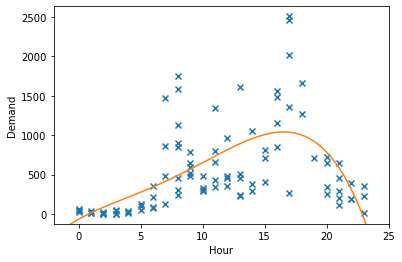

In [51]:
plot_regression_poly(x = xp_rainsnow, y=yp_rainsnow, d = 4)

Mean Squared Error:  167168.08258200355
R^2 Value:  0.46824318872098514
[  7270.52017606   -536.68924361 -11255.70696033   -294.34680374]


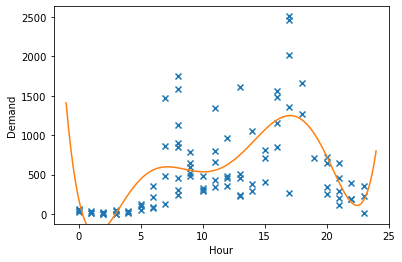

In [52]:
plot_regression_poly(x = xp_rainsnow, y=yp_rainsnow, d = 6)

The predictive results yield similar function behavior (also w.r.t. increases to the polynomial degree) in both cases. This could be interpreted that in the case of 2019's data there could not be observed significant differences for demand behaviour when comparing sunny to rainy/snow days. 

##### Cross-Validation

In [53]:
X = np.array([df_agg_h["hour"].values, np.ones(len(df_agg_h))], dtype=object).T
np.random.seed(10)
perm = np.random.permutation(X.shape[0])
idx_train = perm[:int(len(perm)*0.7)]
idx_cv = perm[int(len(perm)*0.7):]

x_train, y_train = df_agg_h["hour"].iloc[idx_train].values, df_agg_h["demand"].iloc[idx_train].values
x_cv, y_cv = df_agg_h["hour"].iloc[idx_cv].values, df_agg_h["demand"].iloc[idx_cv].values

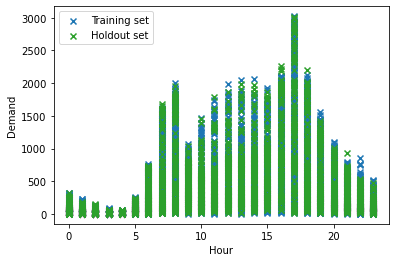

In [54]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_cv, y_cv, marker='x', color="C2")
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.legend(['Training set', 'Holdout set'])

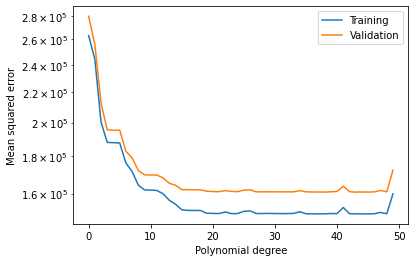

In [55]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)  


err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.savefig('crossvalidation error .png', dpi = 500)

Zooming into the range for d between 0 - 14, we see that a choice of polynomial at/after 5 and before 8 is suitable, since the decrease afterwards starts taking a flat shape. 

Text(0, 0.5, 'Mean squared error')

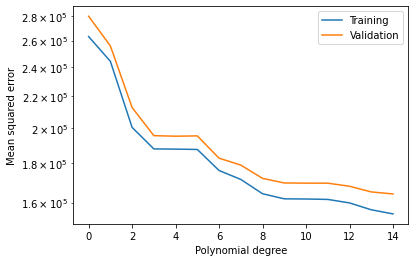

In [56]:
plt.semilogy(range(15), err_train[:15], range(15), err_cv[:15])
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

### Model improvements - Lever: L-2 Regularization

In [57]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression
# lam is lambda, the degree of regularization

def plot_regularized_polyregression (x, y, lam, d):
    
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x) - 1
    
    #xs = x
    
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    theta = np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    #xt = xt0 
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    #Calculating Mean Squared Error
    predictions = X @ theta
    mse = ((predictions - y) ** 2).mean()
    print("Mean Squared Error: ", mse)

    #Calculating R^2 value
    r_squared = 1 - (np.sum((y - predictions) ** 2)) / (np.sum((y - y.mean()) ** 2))
    print("R^2 Value: ", r_squared)
      
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Hour")
    plt.ylabel("Demand")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])
    #plt.savefig('all data_Regularised reg_'+str(d)+'.png', dpi = 300)

Mean Squared Error:  136645.94425352066
R^2 Value:  0.6638286600908403
[-19292.63142694   8764.49568621  44666.95696332 -15338.59693576]


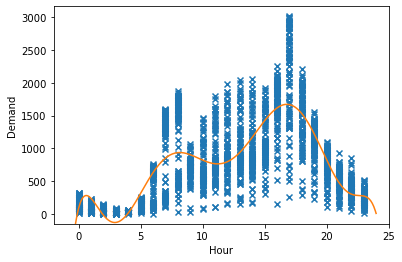

In [58]:
plot_regularized_polyregression(x = xp, y= yp, lam = 0, d = 8)

Mean Squared Error:  140781.3574169182
R^2 Value:  0.6536548683123002
[ -8312.91567492   7562.50377538  22633.64122215 -13233.70064796]


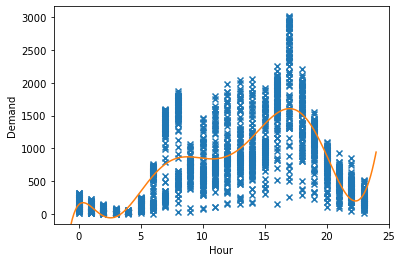

In [59]:
plot_regularized_polyregression(x = xp, y= yp, lam = 0.01, d = 8)

Mean Squared Error:  127697.24098356243
R^2 Value:  0.7045434656713154
[ -1589.36929797   7190.5733741   12114.25443943 -13269.15763523]


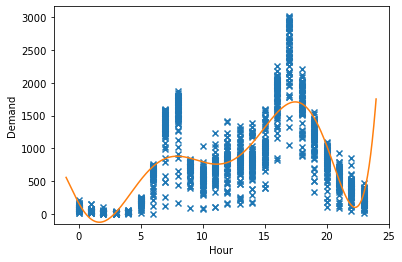

In [60]:
plot_regularized_polyregression(x = xp_weekday, y= yp_weekday, lam = 0.03, d = 8)

Mean Squared Error:  173474.42444400885
R^2 Value:  0.5986275674704069
[ 2140.33038659   297.63608647  -449.89914403 -1299.61919722]


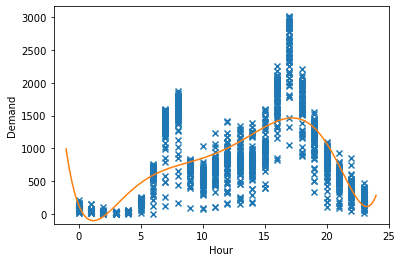

In [61]:
plot_regularized_polyregression(x = xp_weekday, y= yp_weekday, lam = 1, d = 8)

In [62]:
def ls_poly_reg(x, y, lam, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

Text(0, 0.5, 'Coefficient weight')

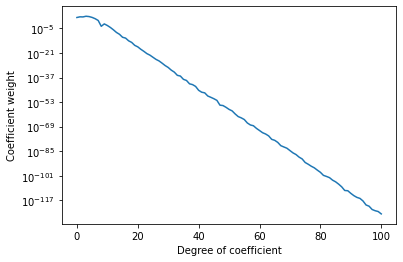

In [63]:
Theta = ls_poly_reg (x = xp, y= yp, lam = 10, degree = 100)
plt.semilogy(range(101), np.abs(Theta[::-1]))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")

In [64]:
def ls_poly_reg(x, y, lam, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

lam = np.logspace(-15,10,100)

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

phi_train = poly_feat(x_train, 100)
phi_cv = poly_feat(x_cv,100)
err_train = [((phi_train @ ls_poly_reg(x_train, y_train, l, 100) - y_train)**2).mean() for l in lam]

### Decision-Tree Regression

In [65]:
Xp = df_f["hour"].values
Yp = df_f["demand"].values

In [66]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def plot_tree_regression_line(tree_depth):

    # Fit regression model (to full data)
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,
                                    criterion="squared_error") 
    Tree_reg.fit(Xp.reshape((-1,1)), Yp)
    Y_pred = Tree_reg.predict(Xp.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(Xp, Yp, marker="x")
    plt.plot(np.arange(0,24,1), Tree_reg.predict(np.arange(0,24,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("Hour", fontsize=16)
    plt.ylabel("Demand", fontsize=16)
    plt.semilogy
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    mse = mean_squared_error(Yp, Y_pred)
    print("Mean Squared Error: ", mse)
    print("R^2: ", r2_score(Yp, Y_pred))
    
    
    #plt.savefig("Peak_Demand_Regression_Lines_{}depth.pdf".format(tree_depth))

number of nodes:  23
number of leafs:  12
Mean Squared Error:  125478.09332599826
R^2:  0.6913033973084013


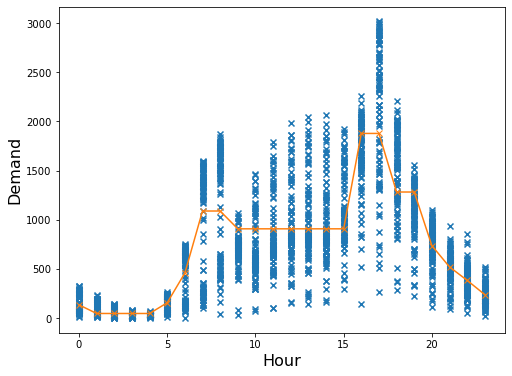

In [67]:
plot_tree_regression_line(4)

number of nodes:  39
number of leafs:  20
Mean Squared Error:  110002.84984049933
R^2:  0.729375023702879


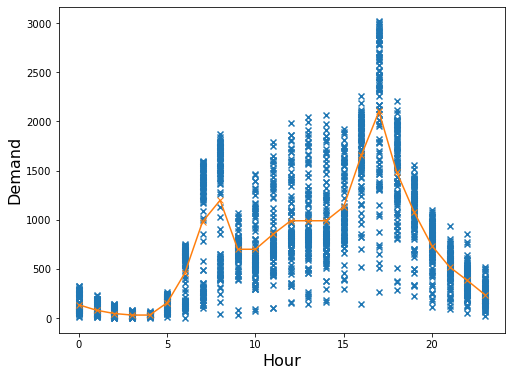

In [68]:
plot_tree_regression_line(6)

number of nodes:  47
number of leafs:  24
Mean Squared Error:  109983.64737947591
R^2:  0.7294222648931468


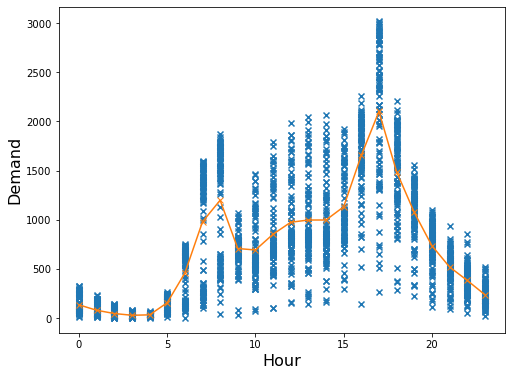

In [69]:
plot_tree_regression_line(8)

number of nodes:  47
number of leafs:  24
Mean Squared Error:  109983.64737947591
R^2:  0.7294222648931468


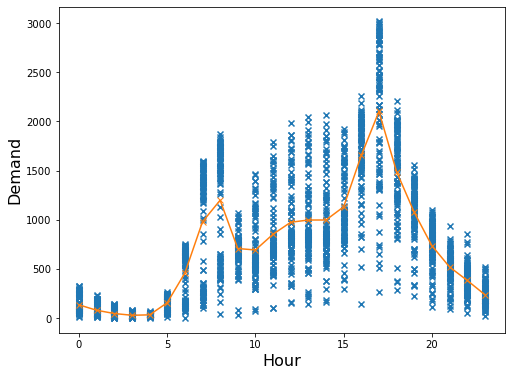

In [70]:
plot_tree_regression_line(100)

Model Evaluation: One can see that increasing the tree depths up to 8 also leads to useful increases in the R^2 such that the explanative power of the model increases. 
Further increasing the tree depths (example d = 100) does not lead to better predictions and R^2. 

The model building and evaluation of the results implies for use of predictive demand modeling:
1) A segmentation into Weekdays and Weekend which it's own distinct demand patterns (most namely due to commuting on work days) and predictions 
2) Polynomial regression or decision tree regression with regularization lead to precise predictions 